<a href="https://colab.research.google.com/github/Ctrl408/neurogym/blob/master/File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets
import gym
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

!git clone https://github.com/gyyang/neurogym.git  # Install neurogym
%cd neurogym/
import neurogym as ngym 
from neurogym.core import TrialEnv

from torchvision import transforms

if torch.cuda.is_available():
  torch.cuda
  device="cuda"
else:device="cpu"

Cloning into 'neurogym'...
remote: Enumerating objects: 10940, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 10940 (delta 59), reused 74 (delta 25), pack-reused 10827
Receiving objects: 100% (10940/10940), 8.16 MiB | 5.19 MiB/s, done.
Resolving deltas: 100% (8245/8245), done.
/content/neurogym


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:422: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  "The `registry.all` method is deprecated. Please use `registry.values` instead."


###Training CNN on MNIST for Classification

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



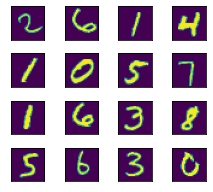

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

traindata= datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)

testdata= datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationloader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

traindata = enumerate(trainloader)
batch_idx, (images, labels) = next(traindata)

testdata = enumerate(validationloader)
batch_idx_t, (images_t, labels_t) = next(testdata)

fig = plt.figure(figsize=(3,3))
for i in range(16):

    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='viridis')
    plt.yticks([])
    plt.xticks([])
fig.subplots_adjust(wspace=0.6, hspace=0.01)

In [ ]:

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
       
        self.layers = nn.Sequential(
                
            nn.Conv2d(1,12,3,1,1),     #in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
            nn.ReLU(),    
            nn.MaxPool2d(kernel_size=2),                            
            nn.Conv2d(12,24,3,1,1), #in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),           
            nn.MaxPool2d(kernel_size=2))

        self.linear_layers = nn.Sequential(          
            nn.Linear(in_features=24*7*7, out_features=64),          
            nn.ReLU(),
            nn.Dropout(p=0.2), 
            nn.Linear(in_features=64, out_features=10) 
        )

    def forward(self, x):
        x = self.layers(x) 
        x = x.view(x.size(0), -1)       
        x = self.linear_layers(x)
        return x

ConvNet= ConvNet()
ConvNet.to(device)

ConvNet(
  (layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:

train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

optimizer = optim.SGD(ConvNet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
      
    total_train_loss = 0
    total_val_loss = 0

    ConvNet.train()
    
    total = 0
    # training 
    for idx, (image, label) in enumerate(trainloader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred =ConvNet(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
print("finished training")

finished training


5


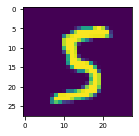

In [ ]:

def Test_ConvNet():
  img = images[12]
  img = img.to(device)
  img = img.view(-1, 1, 28, 28)
  fig=plt.figure(figsize=(2,2))
  plt.imshow(images[12][0], cmap='viridis')
 
  with torch.no_grad():
    logits = ConvNet.forward(img)
    Val= torch.exp(logits)
    Val=Val.cpu()
    probabilities = list(Val.numpy()[0])
    label = probabilities.index(max(probabilities))
    print(label)

Test_ConvNet()

####RNN and Cognitive Neuroscience Task

Modified neurogym sample environment.

In [ ]:

from neurogym.core import TrialEnv 
class Decision(TrialEnv):
    def __init__(self, dt=100, timing=None):
        super().__init__(dt=dt)  
        self.timing = {'stimulus': 500, 'decision': 500}

        if timing:
            self.timing.update(timing)
        
        self.observation_space = gym.spaces.Box(low=-1.0, high=9.0, shape=(1,))
        self.action_space = gym.spaces.Discrete(2)

    def new_trial(self,truth,action=None):
        
        periods = ['stimulus', 'decision']        
        self.add_period(periods)

        stimulus = np.random.uniform((truth-1), truth, size=(1,))
        
        trial = dict()
        trial['stimulus'] = stimulus
        # Ground-truth is 1 if stimulus > 0,
        #2 if >1, 3 if >2 etc...
        trial['ground_truth']=truth       
        
        if self.in_period('stimulus'):
            reward = 0
        else:       
            reward = (action == self.trial['ground_truth']) * 1.0
        
        done =None
        
        info = {'new_trial': False}
        return  stimulus,truth,reward, done, info
Decision=Decision(dt=100)
#Test Decision 
truth=3
import numpy as np 
stimulus = np.random.uniform((truth-1), truth, size=(1,))
print(stimulus)

stimulus=[]
labels=[]

[2.17344789]


In [ ]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(1, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        out, hidden = self.lstm(x)
        x = self.linear(out)
        return x, out
net = RNN(input_size=1,
          hidden_size=10,
          output_size=1)
net = net.to(device)

In [ ]:

#Data
stimulus=[]
labels=[]

for idx, (image, label) in enumerate(trainloader):
   
    label= label.cpu().detach().numpy()
    for n in label:
      val,val1,_,_,_=Decision.new_trial(truth=n)
      stimulus.append(val)
      labels.append(val1)

stimulus=[stimulus[i:i + 600] for i in range(0, len(stimulus), 600)]
labels=[labels[i:i + 600] for i in range(0, len(labels), 600)]

#train

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

a=[100,200,400,500,600,700]

loses=[]
for i in range(100):
  for img,lbl in zip(stimulus,labels):
   
    optimizer.zero_grad()
    img=torch.tensor(img,dtype=torch.float32)
    img=img.to(device)
    lbl=torch.tensor(lbl,dtype=torch.long)
    lbl=lbl.to(device)
    _,pred=net(img)

    Criterion=nn.CrossEntropyLoss()  
    loss=Criterion((pred),lbl)
    if i in a:
      print(loss)
    loses.append(loss)

    loss.backward()
    optimizer.step()

    pred1=[]

print("over")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


over


## Activity

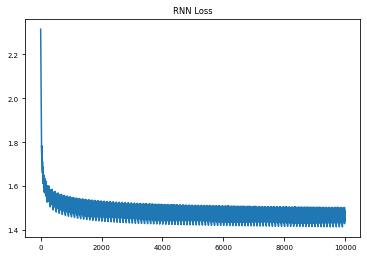

In [ ]:
val=[]
for i in loses:
  i=i.cpu()
  i=i.detach().numpy()
  val.append(i)
plt.title("RNN Loss")
plt.plot(val)

#####Forward Pass <br>
<img src=' https://drive.google.com/uc?id=1_Wxh1VQt7RNCXuWbnKq20SA5vKoJkW_K' height="150" >

In [ ]:

#Test Data

stimulus_t=[]
labels_t=[]
rewards=[]
original_image=[]
original_label=[]
CNN_predictions=[]
RNN_predictions=[]

for idx, (image_t, label_t) in enumerate(validationloader):
    label_a=[]   
    image_t=image_t.to(device)
    for n,z in zip(image_t,label_t):
      original_label.append(z)
      original_image.append((n.cpu()).detach().numpy())
      n = n.view(-1, 1, 28, 28)
      with torch.no_grad():
        logits = ConvNet.forward(n)    
      Val= torch.exp(logits)
      Val=Val.cpu()
      probabilities = list(Val.numpy()[0])
      label = probabilities.index(max(probabilities))   
      label_a.append(label) 
      CNN_predictions.append(label)
    
    for n in label_a:
      action=np.random.choice(9, size=None)
      val,val1,_,_,_=Decision.new_trial(truth=n,action=action)
      stimulus_t.append(val)
      labels_t.append(val1)           

stimulus=[stimulus_t[i:i + 600] for i in range(0, len(stimulus_t), 600)]
labels=[labels_t[i:i + 600] for i in range(0, len(labels_t), 600)]

with torch.no_grad():

  for i in stimulus:
    _,val=net.forward(torch.tensor(i,dtype=torch.float).to(device))

    for x in (val):
      
      val_a=(torch.exp(x)).cpu()
      probabilities = list((val_a.detach().numpy()))
      pred = probabilities.index(max(probabilities))
      RNN_predictions.append(pred)


RNN 3 CNN 6 Ground Truth 6
RNN 4 CNN 4 Ground Truth 4
RNN 7 CNN 7 Ground Truth 7
RNN 1 CNN 1 Ground Truth 1
RNN 4 CNN 4 Ground Truth 4
RNN 3 CNN 6 Ground Truth 6
RNN 7 CNN 7 Ground Truth 7
RNN 2 CNN 2 Ground Truth 2
RNN 4 CNN 4 Ground Truth 4
RNN 7 CNN 7 Ground Truth 7
RNN 1 CNN 1 Ground Truth 1
RNN 7 CNN 9 Ground Truth 9
RNN 2 CNN 2 Ground Truth 2
RNN 0 CNN 0 Ground Truth 0
RNN 4 CNN 4 Ground Truth 4
RNN 7 CNN 7 Ground Truth 7
RNN 2 CNN 2 Ground Truth 2
RNN 1 CNN 1 Ground Truth 1
RNN 4 CNN 5 Ground Truth 5
RNN 7 CNN 9 Ground Truth 9



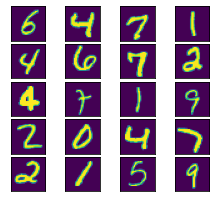

In [ ]:
fig = plt.figure(figsize=(3,3))
for i in range(20):
    ax=plt.subplot(5,4,i+1)
    plt.tight_layout()
    plt.imshow(original_image[i][0], cmap='viridis')
    plt.yticks([])
    ax.set_aspect("equal")
    plt.xticks([])
fig.subplots_adjust(wspace=0.6, hspace=0.01)
print("")
for i in range(20):
  print("RNN",((RNN_predictions)[i]),"CNN",(CNN_predictions)[i],"Ground Truth",(((original_label)[i]).cpu()).detach().numpy())
print("")

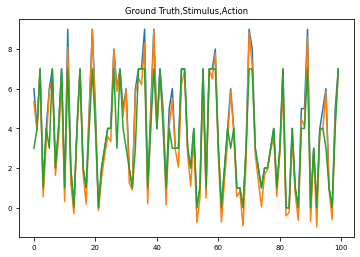

In [ ]:
plt.figure()
plt.title("Ground Truth,Stimulus,Action")
plt.plot(labels_t[0:100])
plt.plot(stimulus_t[0:100])
plt.plot(RNN_predictions[0:100])